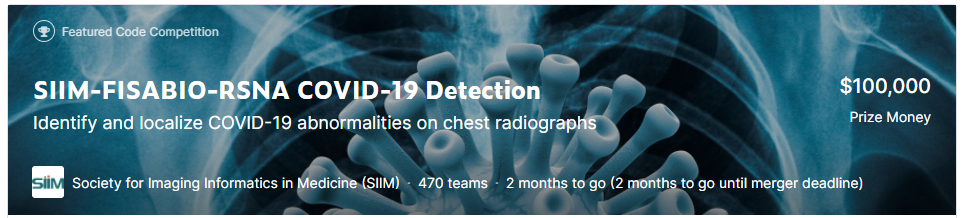

皆さんトレインデータの写真みました？どうやってみて判定すればいいか、いろいろ調べました<br>
カグルマスターに聞いたら、医者じゃなきゃ無理とのこと。モデル作れとのこと。<br>

SSDならなんか判定できちゃうんじゃないかと思ってやってみましたが、まったく学習できません。<br>
人間見てわからないから当たり前ですかね。<br>
さて、どうすればいいんでしょう。

In [ ]:
import os
import seaborn as sns
from pandas_profiling import ProfileReport
import pydicom
from glob import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install pylibjpeg 

1. Typical Appearance: Multifocal bilateral, peripheral opacities with rounded morphology, lower lung–predominant distribution

2. Indeterminate Appearance: Absence of typical findings AND unilateral, central or upper lung predominant distribution

3. Atypical Appearance: Pneumothorax, pleural effusion, pulmonary edema, lobar consolidation, solitary lung nodule or mass, diffuse tiny nodules, cavity

4. Negative for Pneumonia: No lung opacities

In [ ]:
dataset_dir = '../input/siim-covid19-detection'
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=5, size=5, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

 このexposure.equalize_histを施すとクリアに表示される

In [ ]:
#imgs = [exposure.equalize_hist(img) for img in imgs]
#plot_imgs(imgs)

In [ ]:
train = pd.read_csv(f'{dataset_dir}/train_image_level.csv')
train_study = pd.read_csv(f'{dataset_dir}/train_study_level.csv')

In [ ]:
train.head(5)

In [ ]:
train_study.head(5)

In [ ]:
train_study['Negative for Pneumonia'].sum()+train_study['Typical Appearance'].sum()+train_study['Indeterminate Appearance'].sum()+train_study['Atypical Appearance'].sum()

In [ ]:
len(train_study)

6054件。ということはトレインデータからは、各項目のうちどれかが１つだけフラグがたっていることになる。２つの項目にフラグが立つことはないはず。

In [ ]:
train_study['StudyInstanceUID'] = train_study['id'].apply(lambda x: x.replace('_study', ''))
del train_study['id']
train = train.merge(train_study, on='StudyInstanceUID')

In [ ]:
train

In [ ]:
#train = train[~train.boxes.isnull()] 
class_names = ['Typical Appearance','Negative for Pneumonia', 'Indeterminate Appearance', 'Atypical Appearance']
unique_classes = np.unique(train[class_names].values, axis=0)
imgs = []
label2color = {
    '[1, 0, 0, 0]': [255,0,0], # Typical Appearance
    '[0, 1, 0, 0]': [0,255,0], # Indeterminate Appearance
    '[0, 0, 1, 0]': [0,0,255], # Atypical Appearance
    '[0, 0, 0, 1]': [255,255,0], # Negative for Pneumonia
}

In [ ]:
#!pip install GDCM
#!pip install pylibjpeg
#!python -m pip install pydicom
#!pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg
#!pip install git+https://github.com/pydicom/pydicom.git

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pydicom

#path ='../input/siim-covid19-detection/train/8f668881cb15/84baf9c3b2be/7bc56e205e08.dcm'
#ds = pydicom.dcmread(path)
#plt.imshow(ds.pixel_array,cmap=None)

#img = dicom2array(path=path)
#plt.imshow(img, cmap=cmap)
#plt.show()

In [ ]:
!pip install '../input/k/tensorchoko/torch-text/torch-1.2.0-cp37-cp37m-manylinux1_x86_64.whl'
!pip install '../input/k/tensorchoko/torch-text/torch_stable.html'
!pip install '../input/k/tensorchoko/torch-text/torchtext-0.5.0-py3-none-any.whl'
!pip install '../input/k/tensorchoko/torch-text/torchvision-0.4.0-cp37-cp37m-manylinux1_x86_64.whl'

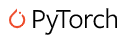

In [ ]:
import warnings
warnings.simplefilter('ignore')
import os
import glob
import os.path as osp
import random
import numpy as np
import json
import cv2
import time
from PIL import Image
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict #
import pathlib
import matplotlib as mpl
import numpy as np
import urllib.request
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models,transforms
from itertools import product
from math import sqrt
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import datetime
import pytz

In [ ]:
import os
import sys

sys.path.append(os.path.join('../input/ssdutiilty/'))

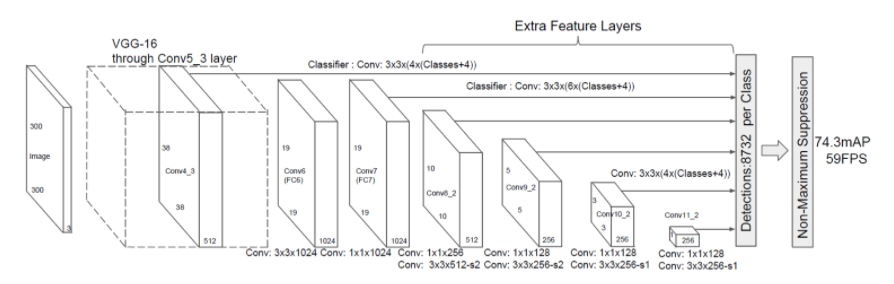

In [ ]:
from data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

from ssd_model import make_datapath_list, od_collate_fn  # VOCDataset,DataTransform, Anno_xml2list,
from ssd_model import SSD,MultiBoxLoss
class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズを300x300にする。
    学習時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (B, G, R)
        各色チャネルの平均値。
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
                ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                PhotometricDistort(),  # 画像の色調などをランダムに変化
                #Expand(color_mean),  # 画像のキャンバスを広げる
                #RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                RandomMirror(),  # 画像を反転させる
                ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, boxes, labels)

In [ ]:
LABEL_CODE1 = {'[0 0 0 1]':0,'[0 0 1 0]': 1, '[0 1 0 0]': 2, '[1 0 0 0]':3}
LABEL_CODE2 = {0:'[0 0 0 1]',1:'[0 0 1 0]',2: '[0 1 0 0]',3: '[1 0 0 0]'}
class_names = ['Typical Appearance','Negative for Pneumonia', 'Indeterminate Appearance', 'Atypical Appearance']

In [ ]:
unique_classes = np.unique(train[class_names].values, axis=0)
unique_classes

In [ ]:
train.iloc[0]

In [ ]:
class Anno_xml2list(): 
  
  def __init__(self,classes): 
    self.clases = classes 
  
  def __call__(self,index,width,height):
      bboxes = []
      row = train.iloc[index]
      bbox = []
      for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        if (i % 6 == 2) | (i % 6 == 4):
            bbox.append(float(l)/width)
        if (i % 6 == 3) | (i % 6 == 5):
            bbox.append(float(l)/height)
        if i % 6 == 5:
            bbox.append(LABEL_CODE1[str(row[class_names].values)])
            bboxes.append(bbox)
            bbox = []    
            
      return np.array(bboxes) #

In [ ]:
dataset_dir = '../input/siim-covid19-detection'
#train = train[~train.boxes.isnull()] 
class_names = ['Typical Appearance','Negative for Pneumonia', 'Indeterminate Appearance', 'Atypical Appearance']
unique_classes = np.unique(train[class_names].values, axis=0)
imgs = []
thickness = 4
scale = 5
for a, row in train.iloc[:3].iterrows():
    study_id = row['StudyInstanceUID']
    file = '../input/smmsize300/train/train/{}.jpg'.format(study_id)
    print(file)
    #img_path = glob.glob(f'{dataset_dir}/train/{study_id}/*/*')[0]
    img = cv2.imread(file)
    #img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    #img = np.stack([img, img, img], axis=-1)
    #img = exposure.equalize_hist(img)
        
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    annotation = '../input/smmsize300/annotation'
    bboxes = annotation[a]

    plt.imshow(img)
   
    plt.show()

In [ ]:
i=0
image_file_path = train.iloc[i]

study_id = train.iloc[i]['StudyInstanceUID']
file ='../input/smmsize300/train/train/{}.jpg'.format(study_id)
img = cv2.imread(file)
height,width,h = img.shape

transform_anno =Anno_xml2list(LABEL_CODE1)
anno_list = transform_anno(i,height,width)
plt.imshow(img, cmap='gray')
plt.show()

input_size=300
color_mean=(104,117,123)

transform = DataTransform(input_size,color_mean)
                     
phase = 'train'
img_transformed,boxes,labels = transform(img, phase,  anno_list[:,:4] ,anno_list[:,4])
plt.imshow(img_transformed,cmap='gray')
plt.show()
LABEL_CODE1[str(row[class_names].values)]

In [ ]:
class VOCDataset(data.Dataset):
 
    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train もしくは valを指定
        self.transform = transform  # 画像の変形
        self.transform_anno = transform_anno  # アノテーションデータをxmlからリストへ
 
    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)
 
    def __getitem__(self, index):
        '''
        前処理をした画像のテンソル形式のデータとアノテーションを取得
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt,h,w
 
    def pull_item(self, index):
        '''前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する'''
 
        # 1. 画像読み込み
        #仮対応   
        #if index==3215:
        #    index =1
            
        study_id = train.iloc[index]['StudyInstanceUID']
        #img_path = glob.glob(f'{dataset_dir}/train/{study_id}/*/*')[0]
               
       
        flag=0
        img_path = '../input/smmsize300/train/train/{}.jpg'.format(study_id)   
        img = cv2.imread(img_path)
        
        #print(len(img.shape))
        if len(img.shape) ==2:
          height,width, = img.shape
        if len(img.shape) ==3:
          height,width,channel = img.shape
        
        #img = np.stack([img, img, img], axis=-1) =>#shapeが4となり動かない
        #img = exposure.equalize_hist(img)
        
        #2. xml形式のアノテーション情報をリストに
        anno_list = transform_anno(index,width,height)
        
        # 3. 前処理を実施
        img, boxes, labels = transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])
 
        # 色チャネルの順番がBGRになっているので、RGBに順番変更
        # さらに（高さ、幅、色チャネル）の順を（色チャネル、高さ、幅）に変換
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)
 
        # BBoxとラベルをセットにしたnp.arrayを作成、変数名「gt」はground truth（答え）の略称
        #print(labels)
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
 
        return img, gt, height, width #imgがtensor,それ以外がarrayとな



In [ ]:
# 動作確認

input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train.iloc[:6000]['StudyInstanceUID'], anno_list[:6000], phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(LABEL_CODE1))

val_dataset = VOCDataset(train.iloc[6000:]['StudyInstanceUID'], anno_list[6000:], phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(LABEL_CODE1))


batch_size = 32 #4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# データの取り出し例
train_dataset.__getitem__(0)


In [ ]:
# 動作の確認
batch_iterator = iter(dataloaders_dict["train"])  # イタレータに変換
images, targets = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[0].size())  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数

In [ ]:
# SSD300の設定
ssd_cfg = {
    'num_classes': 5,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    
    #'steps': [8, 16, 32, 40, 64, 80],  # DBOXの大きさを決める
    #'min_sizes': [4,8,16,32,40,64],  # DBOXの大きさを決める
    #'max_sizes': [8,16,32,40,64,80],  # DBOXの大きさを決める
}
 
# SSDネットワークモデル
net = SSD(phase="train", cfg=ssd_cfg)
 
 
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)
 
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)
 
##################### 新しい学習モデルを作成する
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth") 
if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
# SSDの初期の重みを設定
# ssdのvgg部分に重みをロードする
vgg_weights = torch.load('../input/k/tensorchoko/torch-text/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)
#Heの初期値を適用
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)
 
######################  学習済モデルを使う
#model_path =(''./ssdmodel_save.pth'')
#net.load_state_dict(torch.load(model_path))
###################################################################
# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)
 
print('ネットワーク設定完了：学習済みの重みをロードしました')

In [ ]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

In [ ]:
# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

# 損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 最適化手法の設定
#optimizer = optim.Adam(net.parameters(), lr=1e-4, 
#                      betas=(0.9, 0.999), weight_decay=5e-4, amsgrad=False)
optimizer = optim.SGD(net.parameters(), lr=1e-4, # lr=1e-3,
                     momentum=0.9, weight_decay=5e-4)  

In [ ]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('（train）')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は10回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, targets in dataloaders_dict[phase]:

                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # リストの各要素のテンソルをGPUへ

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs = net(images)

                    # 損失の計算
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c
                    #print('loss=',loss,' targets=',targets)

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 20 == 0):  # 20iterに1度、lossを表示
                            t_iter_finish = time.time()
                            dt_now =  datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
                            duration = t_iter_finish - t_iter_start
                            print('iteration  {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration)," ",dt_now)
                            t_iter_start = time.time()
                            #print('loss=',loss,' targets=',targets,' outputs=',outputs) #######

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        epoch_val_loss = 0.0  # epochの損失和

        # ネットワークを保存する
        if ((epoch+1) % 10 == 0):
           torch.save(net.state_dict(), './ssdmodel_save.pth')

In [ ]:
# 学習・検証を実行する
import datetime
num_epochs= 5
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs) 

学習するたびにlossが増える、学べないモデルができてしまいました。どうしたらいいんでしょう？

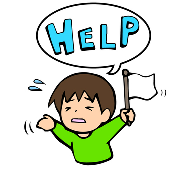
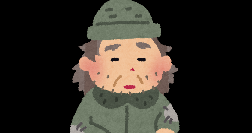

In [ ]:
torch.save(net.state_dict(), './ssdmodel_save.pth')